In [1]:
import numpy as np
import nengo
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import scipy.io
from network_revised import DotPerception, build_network

In [2]:
palette = sns.color_palette("colorblind")
palette2 = sns.color_palette("tab10")[2:4]
palette3 = sns.color_palette("viridis", 10)
sns.set_palette(palette)
sns.set(context='paper', style='ticks', rc={'font.size':12, 'mathtext.fontset': 'cm'})

In [3]:
def single_trial(coherence, nActions, ramp=1, threshold=0.5, perception_seed=0, network_seed=0,
                 dt=0.001, dt_sample=None, tmax=10, legend=False, name="single"):

    inputs = DotPerception(nActions=nActions, dt_sample=dt_sample, seed=perception_seed)
    inputs.create(coherence=coherence)
    net = build_network(inputs, nActions=nActions, seed=network_seed, ramp=ramp, threshold=threshold)
    sim = nengo.Simulator(net, progress_bar=False)
    choice = None
    RT = None
    while choice==None:
        sim.run(dt)
        if np.any(sim.data[net.pAction][-1,:] > 0):
            choice = np.argmax(sim.data[net.pAction][-1,:])
            RT = sim.trange()[-1]
        if sim.trange()[-1] > tmax:
            break
    correct = 1 if choice==net.inputs.correct else 0

    fig, axes = plt.subplots(nrows=1, ncols=2, sharey=True, figsize=((7.08, 3)))
    for a in range(nActions):
        axes[0].plot(sim.trange(), sim.data[net.pAccumulator][:,a], color=palette[a], label=f"Evidence {a}") 
        axes[1].plot(sim.trange(), sim.data[net.pValue][:,a], color=palette[a], label=f"Value {a}") 
    for a in range(nActions):
        if dt_sample is not None:
            ideal = sim.trange()/dt * net.inputs.motions[a] * net.ramp * dt
            axes[0].plot(sim.trange(), ideal, color=palette[a], label=f"True {a}", linestyle="--") 
#     axes[1].plot(sim.trange(), sim.data[net.pGate], label='threshold', color="black")
    axes[1].plot(sim.trange(), net.threshold*np.ones_like(sim.trange()), label='Threshold', color="red", linestyle=":")
    axes[0].set(ylabel=r"$\mathbf{\hat{x}}(t)$", xlabel="Time (s)", title="Evidence in Accumulator")
    axes[1].set(xlabel="Time (s)", title="Decision Criteria")
    if legend:
        axes[0].legend(loc='upper left', ncol=2)
        leg = axes[1].legend(loc='lower right')
        leg.get_texts()[net.inputs.correct].set_color("lime" if correct else "red")
    plt.tight_layout()
    fig.savefig(f"plots/{name}.svg")
    fig.savefig(f"plots/{name}.png", dpi=600)

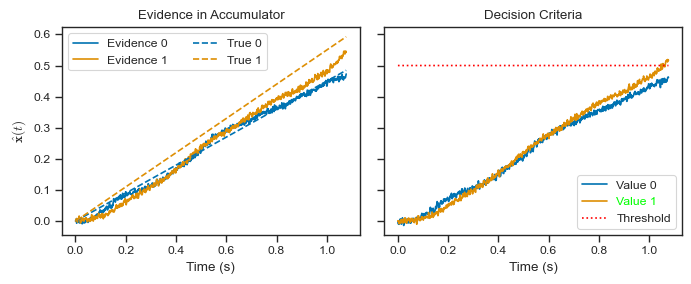

In [4]:
single_trial(coherence=0.1, nActions=2, threshold=0.5, perception_seed=1, dt_sample=0.02, legend=True)

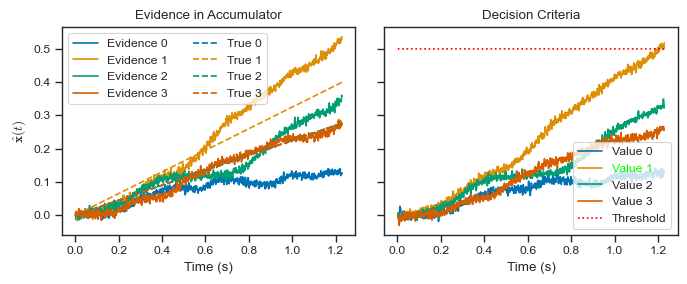

In [5]:
single_trial(coherence=0.1, nActions=4, threshold=0.5, perception_seed=1, dt_sample=0.02, legend=True)

In [6]:
def multiple_trial(coherence,
                   trials=3,
                   perception_seed=0,
                   network_seed=0,
                   dt=0.001,
                   dt_sample=0.02,
                   ramp=1,
                   threshold=0.5,
                   relative=0,
                   nActions=2,
                   tmax=10,
                   name="multiple_trials",
                   **kwargs):
    
    inputs = DotPerception(nActions=nActions, dt_sample=dt_sample, seed=perception_seed)
    inputs.create(coherence=coherence, correct=0)  # force the correct choice to be zero on each trial
    dfs_dynamics = []
    for trial in range(trials):
        print(f"trial {trial}, coherence {coherence}")
        net = build_network(inputs, nActions=nActions, seed=network_seed, ramp=ramp, threshold=threshold)
        sim = nengo.Simulator(net, progress_bar=False)
        choice = None
        RT = None
        while choice==None:
            sim.run(dt)
            if np.any(sim.data[net.pAction][-1,:] > 0):
                choice = np.argmax(sim.data[net.pAction][-1,:])
                RT = sim.trange()[-1]
            if sim.trange()[-1] > tmax:
                break
        correct = 1 if choice==net.inputs.correct else 0
        if choice is not None:
            correct = 1 if choice==net.inputs.correct else 0
            df = pd.DataFrame()
            df['coherence'] = coherence*np.ones_like(sim.trange())
            df['trial'] = trial*np.ones_like(sim.trange())
            df['threshold'] = threshold*np.ones_like(sim.trange())
            df['time'] = sim.trange()
            df['accuracy'] = 100*correct*np.ones_like(sim.trange())
            df['RT'] = 1000*RT*np.ones_like(sim.trange())
            for a in range(nActions):
                df[f'ideal {a}'] = sim.trange()/dt * net.inputs.motions[a] * net.ramp * dt
                df[f'evidence {a}'] = sim.data[net.pAccumulator][:,a].ravel()
                df[f'value {a}'] = sim.data[net.pValue][:,a].ravel()
            dfs_dynamics.append(df)

    data = pd.concat(dfs_dynamics, ignore_index=True)
    data.to_pickle(f"data/{name}.pkl")

    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=((3.5, 3)))
    subdata_correct = data.query("accuracy==100")
    subdata_incorrect = data.query("accuracy==0")
    if not subdata_correct.empty:
        sns.lineplot(data=subdata_correct, x='time', y='value 0', units='trial', estimator=None, lw=0.2, color=palette2[0], ax=ax)
    if not subdata_incorrect.empty:
        sns.lineplot(data=subdata_incorrect, x='time', y='value 0', units='trial', estimator=None, lw=0.2, color=palette2[1], ax=ax)
    sns.lineplot(data=data, x='time', y='ideal 0', color=palette[0], linestyle="--", estimator=None, ax=ax)
    sns.lineplot(data=data, x='time', y='threshold', color="red", linestyle=":", estimator=None, ax=ax)
    ax.set(xlabel="Time (s)", ylabel=r"$\hat{\mathbf{x}}(t)$", ylim=((-0.05, threshold+0.05)))
    plt.tight_layout()
    fig.savefig(f"plots/{name}.svg")
    fig.savefig(f"plots/{name}.png", dpi=600)

trial 0, coherence 0.1
trial 1, coherence 0.1
trial 2, coherence 0.1
trial 3, coherence 0.1
trial 4, coherence 0.1
trial 5, coherence 0.1
trial 6, coherence 0.1
trial 7, coherence 0.1
trial 8, coherence 0.1
trial 9, coherence 0.1


C:\Users\Peter Duggins\speed-accuracy-tradeoff\.venv\Lib\site-packages\nengo\cache.py:609: UserWarning: Decoder cache could not acquire lock and was set to readonly mode.
  warnings.warn(


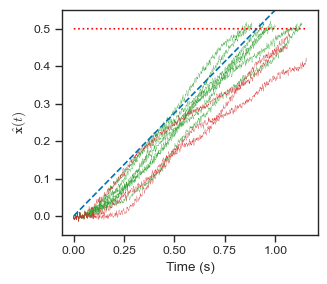

In [7]:
multiple_trial(coherence=0.1, trials=10, perception_seed=3)

In [8]:
def scan_dtsample(coherence,
                   dt_samples,
                   trials=3,
                   perception_seed=0,
                   network_seed=0,
                   dt=0.001,
                   ramp=1,
                   threshold=0.5,
                   relative=0,
                   nActions=2,
                   tmax=10,
                   RTmin=0.2,
                   trials_to_plot=10,
                   name="scan_dtsample",
                   **kwargs):
    
    dfs = []
    dfs2 = []
    for dt_sample in dt_samples:
        inputs = DotPerception(nActions=nActions, dt_sample=dt_sample, seed=perception_seed)
        inputs.create(coherence=coherence, correct=0)  # force the correct choice to be "zero" on each trial
        for trial in range(trials):
            print(f"trial {trial}, coherence {coherence}, dt_sample {dt_sample}")
            net = build_network(inputs, nActions=nActions, seed=network_seed+trial, ramp=ramp, threshold=threshold)
            sim = nengo.Simulator(net, progress_bar=False)
            choice = None
            RT = None
            while choice==None:
                sim.run(dt)
                if np.any(sim.data[net.pAction][-1,:] > 0):
                    choice = np.argmax(sim.data[net.pAction][-1,:])
                    RT = sim.trange()[-1]
                if sim.trange()[-1] > tmax:
                    break
            correct = 1 if choice==net.inputs.correct else 0
            if choice is not None and RT>RTmin:
                correct = 1 if choice==net.inputs.correct else 0
                if trial < trials_to_plot:
                    df = pd.DataFrame()
                    df['coherence'] = coherence*np.ones_like(sim.trange())
                    df['trial'] = trial*np.ones_like(sim.trange())
                    df['threshold'] = threshold*np.ones_like(sim.trange())
                    df['dt_sample'] = dt_sample*np.ones_like(sim.trange())
                    df['time'] = sim.trange()
                    df['accuracy'] = 100*correct*np.ones_like(sim.trange())
                    df['RT'] = 1000*RT*np.ones_like(sim.trange())
                    for a in range(nActions):
                        df[f'ideal {a}'] = sim.trange()/dt * net.inputs.motions[a] * net.ramp * dt
                        df[f'evidence {a}'] = sim.data[net.pAccumulator][:,a].ravel()
                        df[f'value {a}'] = sim.data[net.pValue][:,a].ravel()
                    dfs.append(df)
                dfs2.append(pd.DataFrame([[trial, f"{coherence}", f"{dt_sample}", RT, 100*correct]],
                                         columns=('trial', 'coherence', 'dt_sample', 'RT', 'accuracy')))

    data = pd.concat(dfs, ignore_index=True)
    data2 = pd.concat(dfs2, ignore_index=True)
    data.to_pickle(f"data/{name}.pkl")
    data2.to_pickle(f"data/{name}_result.pkl")

    fig, axes = plt.subplots(nrows=2, ncols=2, sharex=True, sharey=True, figsize=((7.08, 4)))
    for a in range(2):
        for b in range(2):
            dts = dt_samples[2*a+b]
            maxtrial = np.min([trials, trials_to_plot])
            subdata = data.query("dt_sample==@dts & trial<=@maxtrial")
            subdata_correct = subdata.query("accuracy==100")
            subdata_incorrect = subdata.query("accuracy==0")
            if not subdata_correct.empty:
                sns.lineplot(data=subdata_correct, x='time', y='value 0', units='trial', estimator=None, lw=0.2, color=palette2[0], ax=axes[a][b])
            if not subdata_incorrect.empty:
                sns.lineplot(data=subdata_incorrect, x='time', y='value 0', units='trial', estimator=None, lw=0.2, color=palette2[1], ax=axes[a][b])
            sns.lineplot(data=subdata, x='time', y='ideal 0', color=palette[0], linestyle="--", estimator=None, ax=axes[a][b])
            sns.lineplot(data=subdata, x='time', y='threshold', color="red", linestyle=":", estimator=None, ax=axes[a][b])
            axes[a][b].set(xlabel="Time (s)", ylabel=r"$\hat{\mathbf{x}}(t)$", title=f"dt_sample {dts}", ylim=((-0.05, threshold+0.05)))
    plt.tight_layout()
    fig.savefig(f"plots/{name}.svg")
    fig.savefig(f"plots/{name}.png", dpi=600)

    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=((3.5, 3)))
    sns.histplot(data=data2, x='RT', hue='dt_sample', stat='percent', element="poly", ax=ax)
    ax.set(xlabel='Response Time (s)')
    plt.tight_layout()
    fig.savefig(f"plots/{name}_RT_distributions.svg")
    fig.savefig(f"plots/{name}_RT_distributions.png", dpi=600)

trial 0, coherence 0.1, dt_sample 0
trial 1, coherence 0.1, dt_sample 0
trial 2, coherence 0.1, dt_sample 0
trial 3, coherence 0.1, dt_sample 0
trial 4, coherence 0.1, dt_sample 0
trial 5, coherence 0.1, dt_sample 0
trial 6, coherence 0.1, dt_sample 0
trial 7, coherence 0.1, dt_sample 0
trial 8, coherence 0.1, dt_sample 0
trial 9, coherence 0.1, dt_sample 0
trial 10, coherence 0.1, dt_sample 0
trial 11, coherence 0.1, dt_sample 0
trial 12, coherence 0.1, dt_sample 0
trial 13, coherence 0.1, dt_sample 0
trial 14, coherence 0.1, dt_sample 0
trial 15, coherence 0.1, dt_sample 0
trial 16, coherence 0.1, dt_sample 0
trial 17, coherence 0.1, dt_sample 0
trial 18, coherence 0.1, dt_sample 0
trial 19, coherence 0.1, dt_sample 0
trial 20, coherence 0.1, dt_sample 0
trial 21, coherence 0.1, dt_sample 0
trial 22, coherence 0.1, dt_sample 0
trial 23, coherence 0.1, dt_sample 0
trial 24, coherence 0.1, dt_sample 0
trial 25, coherence 0.1, dt_sample 0
trial 26, coherence 0.1, dt_sample 0
trial 27, c

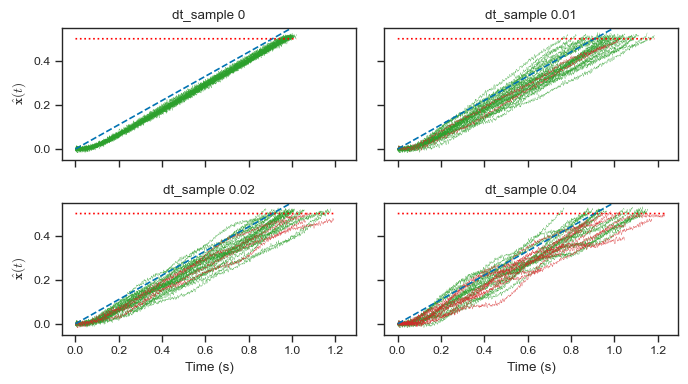

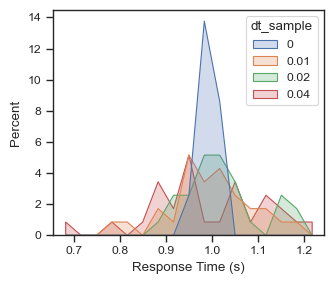

In [9]:
scan_dtsample(coherence=0.1, dt_samples=[0, 0.01, 0.02, 0.04], trials=30, trials_to_plot=30)

In [10]:
def absolute_vs_relative(coherence,
                   perception_seed=0,
                   network_seed=0,
                   dt=0.001,
                   ramp=1,
                   threshold=0.5,
                   nActions=2,
                   tmax=10,
                   RTmin=0.2,
                   dt_sample=0.02,
                   name="absolute_vs_relative",
                   **kwargs):
    
    dfs = []
    inputs = DotPerception(nActions=nActions, dt_sample=dt_sample, seed=perception_seed)
    inputs.create(coherence=coherence)
    net = build_network(inputs, nActions=nActions, seed=network_seed, ramp=ramp, threshold=threshold, relative=1, **kwargs)
    sim = nengo.Simulator(net, progress_bar=False)
    choice = None
    RT = None
    while choice==None:
        sim.run(dt)
        if np.any(sim.data[net.pAction][-1,:] > 0):
            choice = np.argmax(sim.data[net.pAction][-1,:])
            RT = sim.trange()[-1]
        if sim.trange()[-1] > tmax:
            break
    correct = 1 if choice==net.inputs.correct else 0
    if choice is not None and RT>RTmin:
        correct = 1 if choice==net.inputs.correct else 0
        df = pd.DataFrame()
        df['coherence'] = coherence*np.ones_like(sim.trange())
        df['threshold'] = threshold*np.ones_like(sim.trange())
        df['dt_sample'] = dt_sample*np.ones_like(sim.trange())
        df['time'] = sim.trange()
        df['accuracy'] = 100*correct*np.ones_like(sim.trange())
        df['RT'] = 1000*RT*np.ones_like(sim.trange())
        for a in range(nActions):
            df[f'ideal {a}'] = sim.trange()/dt * net.inputs.motions[a] * net.ramp * dt
            df[f'evidence {a}'] = sim.data[net.pAccumulator][:,a].ravel()
            df[f'value {a}'] = sim.data[net.pValue][:,a].ravel()
        dfs.append(df)
    data = pd.concat(dfs, ignore_index=True)
    data.to_pickle(f"data/{name}.pkl")

    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=((7.08, 3)))
    sns.lineplot(data=data, x='time', y='evidence 0', color=palette[0], ax=axes[0])  #, label="raw evidence 0")
    sns.lineplot(data=data, x='time', y='evidence 1', color=palette[1], ax=axes[0])  #, label="raw evidence 1")
    sns.lineplot(data=data, x='time', y='value 0', color=palette[0], ax=axes[1])  #, label="relative value 0")
    sns.lineplot(data=data, x='time', y='value 1', color=palette[1], ax=axes[1])  #, label="relative value 1")
    sns.lineplot(data=data, x='time', y='threshold', color="red", linestyle=":", estimator=None, ax=axes[0])
    sns.lineplot(data=data, x='time', y='threshold', color="red", linestyle=":", estimator=None, ax=axes[1])
    axes[0].set(title="Absolute Value")
    axes[1].set(title="Relative Value")
    axes[0].set(xlabel="Time (s)", ylabel=r"$\hat{\mathbf{x}}(t)$")
    axes[1].set(xlabel="Time (s)", ylabel=r"$\hat{\mathbf{x}}(t)$")
    # axes[0].legend()
    plt.tight_layout()
    fig.savefig(f"plots/{name}.svg")
    fig.savefig(f"plots/{name}.png", dpi=600)

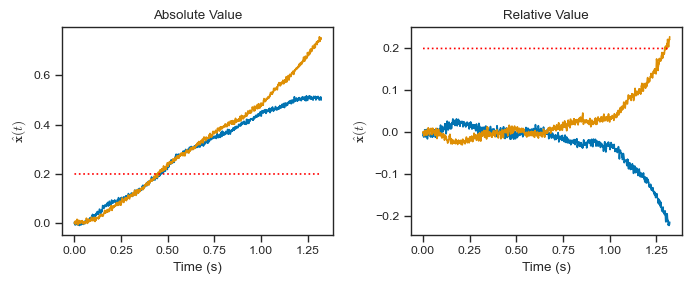

In [11]:
absolute_vs_relative(coherence=0.1, threshold=0.2, perception_seed=1)

In [12]:
def vary_ramp_threshold(coherence,
                   trials=3,
                   nActions=2,
                   perception_seed=0,
                   network_seed=0,
                   dt=0.001,
                   dt_sample=0.02,
                   ramps=[0.5, 1],
                   thresholds=[0.3, 0.5],
                   relative=0,
                   tmax=10,
                   RTmin=0.2,
                   name="vary_ramp_threshold"):

    dfs = []
    inputs = DotPerception(nActions=nActions, dt_sample=dt_sample, seed=perception_seed)
    inputs.create(coherence=coherence, correct=0)  # force choice "zero" to be correct
    for ramp in ramps:
        for threshold in thresholds:
            for trial in range(trials):
                print(f"trial {trial}, ramp {ramp}, threshold {threshold}")
                net = build_network(inputs, seed=network_seed+trial, ramp=ramp, threshold=threshold, relative=relative)
                sim = nengo.Simulator(net, progress_bar=False)
                choice = None
                while choice==None:
                    sim.run(dt)
                    if np.any(sim.data[net.pAction][-1,:] > 0):
                        choice = np.argmax(sim.data[net.pAction][-1,:])
                        RT = sim.trange()[-1]
                    if sim.trange()[-1] > tmax:
                        break
                correct = 1 if choice==net.inputs.correct else 0
                if choice is not None and RT>RTmin:
                    df = pd.DataFrame()
                    df['coherence'] = coherence*np.ones_like(sim.trange())
                    df['trial'] = trial*np.ones_like(sim.trange())
                    df['threshold'] = threshold*np.ones_like(sim.trange())
                    df['ramp'] = ramp*np.ones_like(sim.trange())
                    df['dt_sample'] = dt_sample*np.ones_like(sim.trange())
                    df['time'] = sim.trange()
                    df['accuracy'] = 100*correct*np.ones_like(sim.trange())
                    df['RT'] = 1000*RT*np.ones_like(sim.trange())
                    for a in range(nActions):
                        df[f'ideal {a}'] = sim.trange()/dt * net.inputs.motions[a] * net.ramp * dt
                        df[f'evidence {a}'] = sim.data[net.pAccumulator][:,a].ravel()
                        df[f'value {a}'] = sim.data[net.pValue][:,a].ravel()
                    dfs.append(df)

    data = pd.concat(dfs, ignore_index=True)
    data.to_pickle(f"data/{name}.pkl")
    
    fig, axes = plt.subplots(nrows=2, ncols=2, sharex=True, sharey=True, figsize=((7.08, 4)))
    for r in range(len(ramps)):
        for t in range(len(thresholds)):
            ramp, threshold = ramps[r], thresholds[t]
            subdata = data.query("ramp==@ramp & threshold==@threshold")
            subdata_correct = subdata.query("accuracy==100")
            subdata_incorrect = subdata.query("accuracy==0")
            if not subdata_correct.empty:
                sns.lineplot(data=subdata_correct, x='time', y='value 0', units='trial', estimator=None, lw=0.2, color=palette2[0], ax=axes[r][t])
            if not subdata_incorrect.empty:
                sns.lineplot(data=subdata_incorrect, x='time', y='value 0', units='trial', estimator=None, lw=0.2, color=palette2[1], ax=axes[r][t])            
            sns.lineplot(data=subdata, x='time', y='ideal 0', color=palette[0], linestyle="--", estimator=None, ax=axes[r][t])
            sns.lineplot(data=subdata, x='time', y='threshold', color="red", linestyle=":", estimator=None, ax=axes[r][t])
            axes[r][t].set(xlabel="Time (s)", ylabel=r"$\hat{\mathbf{x}}(t)$", title=f"ramp {ramp}, threshold {threshold}", ylim=((-0.05, threshold+0.05)))
    axes[0][0].set(ylabel=r"$\hat{\mathbf{x}}(t)$")
    axes[1][0].set(xlabel="Time (s)")
    axes[1][1].set(ylabel=r"$\hat{\mathbf{x}}(t)$", xlabel="Time (s)")
    plt.tight_layout()
    fig.savefig(f"plots/{name}.svg")
    fig.savefig(f"plots/{name}.png", dpi=600)

trial 0, ramp 0.5, threshold 0.3
trial 1, ramp 0.5, threshold 0.3
trial 2, ramp 0.5, threshold 0.3


C:\Users\Peter Duggins\speed-accuracy-tradeoff\.venv\Lib\site-packages\nengo\cache.py:609: UserWarning: Decoder cache could not acquire lock and was set to readonly mode.
  warnings.warn(


trial 3, ramp 0.5, threshold 0.3
trial 4, ramp 0.5, threshold 0.3
trial 5, ramp 0.5, threshold 0.3


C:\Users\Peter Duggins\speed-accuracy-tradeoff\.venv\Lib\site-packages\nengo\cache.py:609: UserWarning: Decoder cache could not acquire lock and was set to readonly mode.
  warnings.warn(


trial 6, ramp 0.5, threshold 0.3


C:\Users\Peter Duggins\speed-accuracy-tradeoff\.venv\Lib\site-packages\nengo\cache.py:516: CacheIOWarning: The cache index could not be updated because another program blocked access to it. This is commonly caused by anti-virus software. It is safe to ignore this warning. But if you see it a lot, you might want to consider doing one of the following for the best Nengo performance:
1. Configure your anti-virus to ignore the Nengo cache folder ('C:\Users\Peter Duggins\.nengo\cache\decoders').
2. Disable the cache.

  warnings.warn(


trial 7, ramp 0.5, threshold 0.3
trial 8, ramp 0.5, threshold 0.3
trial 9, ramp 0.5, threshold 0.3
trial 10, ramp 0.5, threshold 0.3
trial 11, ramp 0.5, threshold 0.3
trial 12, ramp 0.5, threshold 0.3
trial 13, ramp 0.5, threshold 0.3
trial 14, ramp 0.5, threshold 0.3
trial 15, ramp 0.5, threshold 0.3
trial 16, ramp 0.5, threshold 0.3


C:\Users\Peter Duggins\speed-accuracy-tradeoff\.venv\Lib\site-packages\nengo\cache.py:516: CacheIOWarning: The cache index could not be updated because another program blocked access to it. This is commonly caused by anti-virus software. It is safe to ignore this warning. But if you see it a lot, you might want to consider doing one of the following for the best Nengo performance:
1. Configure your anti-virus to ignore the Nengo cache folder ('C:\Users\Peter Duggins\.nengo\cache\decoders').
2. Disable the cache.

  warnings.warn(


trial 17, ramp 0.5, threshold 0.3
trial 18, ramp 0.5, threshold 0.3
trial 19, ramp 0.5, threshold 0.3


C:\Users\Peter Duggins\speed-accuracy-tradeoff\.venv\Lib\site-packages\nengo\cache.py:609: UserWarning: Decoder cache could not acquire lock and was set to readonly mode.
  warnings.warn(


trial 20, ramp 0.5, threshold 0.3
trial 21, ramp 0.5, threshold 0.3
trial 22, ramp 0.5, threshold 0.3
trial 23, ramp 0.5, threshold 0.3
trial 24, ramp 0.5, threshold 0.3
trial 25, ramp 0.5, threshold 0.3
trial 26, ramp 0.5, threshold 0.3


C:\Users\Peter Duggins\speed-accuracy-tradeoff\.venv\Lib\site-packages\nengo\cache.py:609: UserWarning: Decoder cache could not acquire lock and was set to readonly mode.
  warnings.warn(


trial 27, ramp 0.5, threshold 0.3
trial 28, ramp 0.5, threshold 0.3
trial 29, ramp 0.5, threshold 0.3
trial 0, ramp 0.5, threshold 0.5
trial 1, ramp 0.5, threshold 0.5
trial 2, ramp 0.5, threshold 0.5
trial 3, ramp 0.5, threshold 0.5
trial 4, ramp 0.5, threshold 0.5
trial 5, ramp 0.5, threshold 0.5
trial 6, ramp 0.5, threshold 0.5
trial 7, ramp 0.5, threshold 0.5


C:\Users\Peter Duggins\speed-accuracy-tradeoff\.venv\Lib\site-packages\nengo\cache.py:609: UserWarning: Decoder cache could not acquire lock and was set to readonly mode.
  warnings.warn(


trial 8, ramp 0.5, threshold 0.5
trial 9, ramp 0.5, threshold 0.5
trial 10, ramp 0.5, threshold 0.5
trial 11, ramp 0.5, threshold 0.5
trial 12, ramp 0.5, threshold 0.5
trial 13, ramp 0.5, threshold 0.5
trial 14, ramp 0.5, threshold 0.5


C:\Users\Peter Duggins\speed-accuracy-tradeoff\.venv\Lib\site-packages\nengo\cache.py:609: UserWarning: Decoder cache could not acquire lock and was set to readonly mode.
  warnings.warn(


trial 15, ramp 0.5, threshold 0.5


C:\Users\Peter Duggins\speed-accuracy-tradeoff\.venv\Lib\site-packages\nengo\cache.py:609: UserWarning: Decoder cache could not acquire lock and was set to readonly mode.
  warnings.warn(


trial 16, ramp 0.5, threshold 0.5
trial 17, ramp 0.5, threshold 0.5
trial 18, ramp 0.5, threshold 0.5


C:\Users\Peter Duggins\speed-accuracy-tradeoff\.venv\Lib\site-packages\nengo\cache.py:609: UserWarning: Decoder cache could not acquire lock and was set to readonly mode.
  warnings.warn(


trial 19, ramp 0.5, threshold 0.5


C:\Users\Peter Duggins\speed-accuracy-tradeoff\.venv\Lib\site-packages\nengo\cache.py:609: UserWarning: Decoder cache could not acquire lock and was set to readonly mode.
  warnings.warn(


trial 20, ramp 0.5, threshold 0.5
trial 21, ramp 0.5, threshold 0.5
trial 22, ramp 0.5, threshold 0.5
trial 23, ramp 0.5, threshold 0.5
trial 24, ramp 0.5, threshold 0.5


C:\Users\Peter Duggins\speed-accuracy-tradeoff\.venv\Lib\site-packages\nengo\cache.py:609: UserWarning: Decoder cache could not acquire lock and was set to readonly mode.
  warnings.warn(


trial 25, ramp 0.5, threshold 0.5
trial 26, ramp 0.5, threshold 0.5
trial 27, ramp 0.5, threshold 0.5
trial 28, ramp 0.5, threshold 0.5


C:\Users\Peter Duggins\speed-accuracy-tradeoff\.venv\Lib\site-packages\nengo\cache.py:609: UserWarning: Decoder cache could not acquire lock and was set to readonly mode.
  warnings.warn(


trial 29, ramp 0.5, threshold 0.5


C:\Users\Peter Duggins\speed-accuracy-tradeoff\.venv\Lib\site-packages\nengo\cache.py:609: UserWarning: Decoder cache could not acquire lock and was set to readonly mode.
  warnings.warn(


trial 0, ramp 1, threshold 0.3
trial 1, ramp 1, threshold 0.3
trial 2, ramp 1, threshold 0.3
trial 3, ramp 1, threshold 0.3
trial 4, ramp 1, threshold 0.3
trial 5, ramp 1, threshold 0.3
trial 6, ramp 1, threshold 0.3
trial 7, ramp 1, threshold 0.3
trial 8, ramp 1, threshold 0.3
trial 9, ramp 1, threshold 0.3
trial 10, ramp 1, threshold 0.3
trial 11, ramp 1, threshold 0.3
trial 12, ramp 1, threshold 0.3
trial 13, ramp 1, threshold 0.3
trial 14, ramp 1, threshold 0.3
trial 15, ramp 1, threshold 0.3
trial 16, ramp 1, threshold 0.3
trial 17, ramp 1, threshold 0.3


C:\Users\Peter Duggins\speed-accuracy-tradeoff\.venv\Lib\site-packages\nengo\cache.py:516: CacheIOWarning: The cache index could not be updated because another program blocked access to it. This is commonly caused by anti-virus software. It is safe to ignore this warning. But if you see it a lot, you might want to consider doing one of the following for the best Nengo performance:
1. Configure your anti-virus to ignore the Nengo cache folder ('C:\Users\Peter Duggins\.nengo\cache\decoders').
2. Disable the cache.

  warnings.warn(


trial 18, ramp 1, threshold 0.3
trial 19, ramp 1, threshold 0.3
trial 20, ramp 1, threshold 0.3
trial 21, ramp 1, threshold 0.3
trial 22, ramp 1, threshold 0.3
trial 23, ramp 1, threshold 0.3
trial 24, ramp 1, threshold 0.3
trial 25, ramp 1, threshold 0.3
trial 26, ramp 1, threshold 0.3
trial 27, ramp 1, threshold 0.3
trial 28, ramp 1, threshold 0.3
trial 29, ramp 1, threshold 0.3
trial 0, ramp 1, threshold 0.5
trial 1, ramp 1, threshold 0.5
trial 2, ramp 1, threshold 0.5
trial 3, ramp 1, threshold 0.5
trial 4, ramp 1, threshold 0.5
trial 5, ramp 1, threshold 0.5
trial 6, ramp 1, threshold 0.5


C:\Users\Peter Duggins\speed-accuracy-tradeoff\.venv\Lib\site-packages\nengo\cache.py:609: UserWarning: Decoder cache could not acquire lock and was set to readonly mode.
  warnings.warn(


trial 7, ramp 1, threshold 0.5
trial 8, ramp 1, threshold 0.5
trial 9, ramp 1, threshold 0.5
trial 10, ramp 1, threshold 0.5
trial 11, ramp 1, threshold 0.5
trial 12, ramp 1, threshold 0.5
trial 13, ramp 1, threshold 0.5
trial 14, ramp 1, threshold 0.5
trial 15, ramp 1, threshold 0.5
trial 16, ramp 1, threshold 0.5


C:\Users\Peter Duggins\speed-accuracy-tradeoff\.venv\Lib\site-packages\nengo\cache.py:609: UserWarning: Decoder cache could not acquire lock and was set to readonly mode.
  warnings.warn(


trial 17, ramp 1, threshold 0.5
trial 18, ramp 1, threshold 0.5
trial 19, ramp 1, threshold 0.5


C:\Users\Peter Duggins\speed-accuracy-tradeoff\.venv\Lib\site-packages\nengo\cache.py:609: UserWarning: Decoder cache could not acquire lock and was set to readonly mode.
  warnings.warn(


trial 20, ramp 1, threshold 0.5
trial 21, ramp 1, threshold 0.5
trial 22, ramp 1, threshold 0.5
trial 23, ramp 1, threshold 0.5
trial 24, ramp 1, threshold 0.5
trial 25, ramp 1, threshold 0.5
trial 26, ramp 1, threshold 0.5
trial 27, ramp 1, threshold 0.5
trial 28, ramp 1, threshold 0.5
trial 29, ramp 1, threshold 0.5


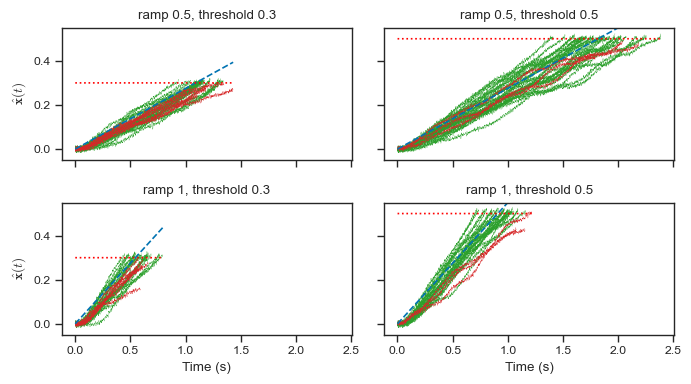

In [13]:
vary_ramp_threshold(coherence=0.1, trials=30)

In [14]:
def scan_coherence_ramp_threshold(
        coherences=np.geomspace(0.01, 1.0, 5),
        ramps=[0.5, 1.0],
        thresholds=[0.3, 0.6],
        nActions=2,
        trials=3,
        perception_seed=0,
        dt=0.001,
        dt_sample=0.02,
        relative=0,
        load=False,
        errbar="se",
        tmax=5,
        RTmin=0.2,
        name="scan_coherence_ramp_threshold"):
    
    if not load:
        inputs = DotPerception(nActions=nActions, dt_sample=dt_sample, seed=perception_seed)
        network_seed = 0
        columns = ('label', 'ramp', 'threshold', 'coherence', 'trial', 'RT', 'accuracy')
        dfs = []
        for ramp in ramps:
            for threshold in thresholds:
                for coherence in coherences:
                    for trial in range(trials):
                        print(f"trial {trial}, coherence {coherence}, ramp {ramp}, threshold {threshold}")
                        network_seed += 1
                        inputs.create(coherence=coherence)
                        net = build_network(inputs, seed=network_seed, ramp=ramp, threshold=threshold, relative=relative)
                        sim = nengo.Simulator(net, progress_bar=False)
                        choice = None
                        while choice==None:
                            sim.run(dt)
                            if np.any(sim.data[net.pAction][-1,:] > 0):
                                choice = np.argmax(sim.data[net.pAction][-1,:])
                                RT = sim.trange()[-1]
                            if sim.trange()[-1] > tmax:
                                choice = np.argmax(sim.data[net.pValue][-1,:])
                                RT = sim.trange()[-1]
                        correct = True if choice==inputs.correct else False
                        if RT > RTmin:
                            label = f"ramp {ramp}, thr {threshold}"
                            dfs.append(pd.DataFrame([[label, ramp, threshold, 100*coherence, trial, RT, 100*correct]], columns=columns))
        data = pd.concat(dfs, ignore_index=True)
        data.to_pickle(f"data/{name}.pkl")
    else:
        data = pd.read_pickle(f"data/{name}.pkl")
    
    fig, axes = plt.subplots(nrows=len(ramps), ncols=len(thresholds), sharex=True, sharey=True, figsize=((7.08, 2*len(ramps))))
    for r in range(len(ramps)):
        for t in range(len(thresholds)):
            ramp, threshold = ramps[r], thresholds[t]
            sns.lineplot(data=data.query("ramp==@ramp & threshold==@threshold"), x='coherence', y='RT', errorbar=errbar, ax=axes[r][t])
            axes[r][t].set(title=f"ramp {ramp}, threshold {threshold}")
    for r in range(len(ramps)):
        axes[r][0].set(ylabel="Response Times (s)")
    for t in range(len(thresholds)):
        axes[len(ramps)-1][t].set(xlabel="Coherence (% motion strength)")
    plt.xscale('log')
    plt.tight_layout()
    fig.savefig(f"plots/{name}_RT.svg")
    fig.savefig(f"plots/{name}_RT.png", dpi=600)

    fig, axes = plt.subplots(nrows=len(ramps), ncols=len(thresholds), sharex=True, sharey=True, figsize=((7.08, 2*len(ramps))))
    for r in range(len(ramps)):
        for t in range(len(thresholds)):
            ramp, threshold = ramps[r], thresholds[t]
            sns.lineplot(data=data.query("ramp==@ramp & threshold==@threshold"), x='coherence', y='accuracy', errorbar=errbar, ax=axes[r][t])
            axes[r][t].set(title=f"ramp {ramp}, threshold {threshold}")
    for r in range(len(ramps)):
        axes[r][0].set(ylabel="Accuracy (%)")
    for t in range(len(thresholds)):
        axes[len(ramps)-1][t].set(xlabel="Coherence (% motion strength)")
    plt.xscale('log')
    plt.tight_layout()
    fig.savefig(f"plots/{name}_accuracy.svg")
    fig.savefig(f"plots/{name}_accuracy.png", dpi=600)

    fig = sns.FacetGrid(data, row="coherence", hue="label", palette=palette, height=1.15, aspect=3)
    fig.map_dataframe(sns.histplot, x="RT", stat='probability', element="poly", bins=np.arange(0.2, 2.6, 0.2), common_norm=False)
    fig.set_xlabels("Reaction Time (s)")
    fig.add_legend()
    fig.savefig(f"plots/{name}_distributions.svg")
    fig.savefig(f"plots/{name}_distributions.png", dpi=600)

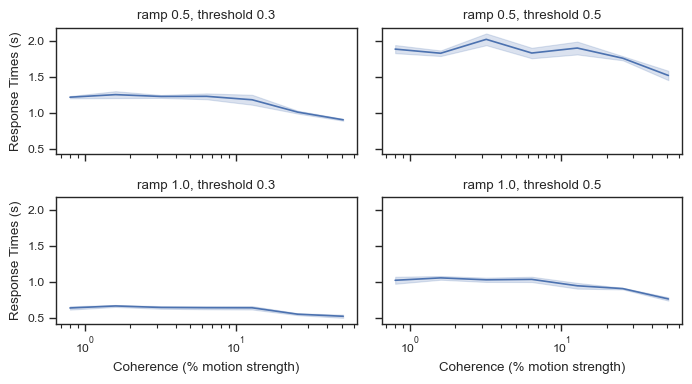

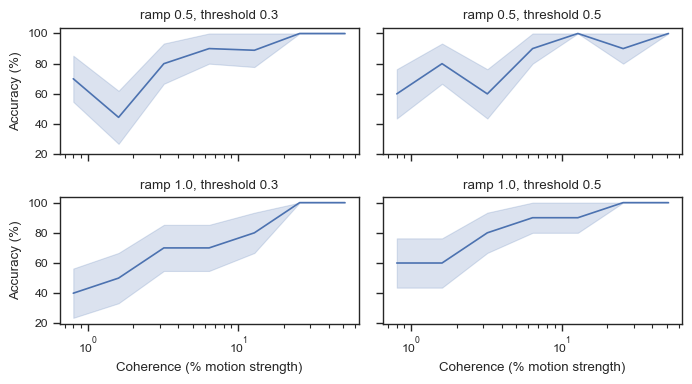

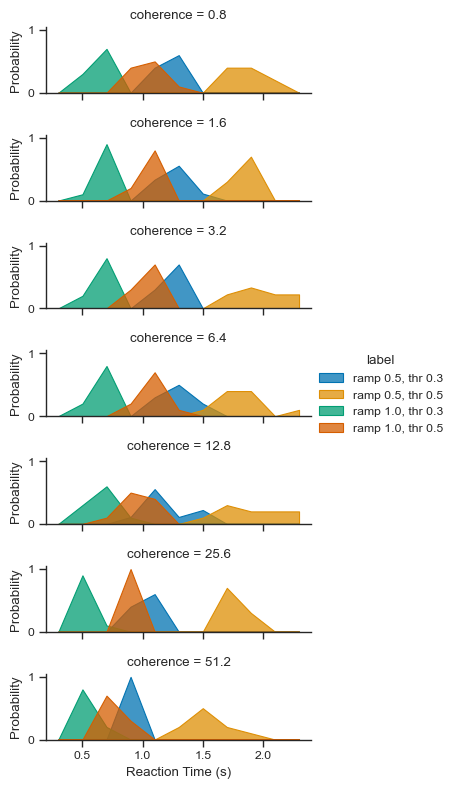

In [15]:
scan_coherence_ramp_threshold(
        load=True,
        coherences=[0.008, 0.016, 0.032, 0.064, 0.128, 0.256, 0.512],
        ramps=[0.5, 1.0],
        thresholds=[0.3, 0.5],
        trials=10)

In [18]:
def scan_coherence_nActions(
        coherences=np.geomspace(0.01, 1.0, 5),
        nActions_list=[2, 4],
        ramp=1.0,
        threshold=0.5,
        trials=3,
        perception_seed=0,
        network_seed=0,
        dt=0.001,
        dt_sample=0.02,
        relative=0,
        load=False,
        tmax=5,
        RTmin=0.2,
        name="scan_coherence_nActions"):
    
    if not load:
        columns = ('nActions', 'coherence', 'trial', 'RT', 'accuracy')
        dfs = []
        for nActions in nActions_list:
            inputs = DotPerception(nActions=nActions, dt_sample=dt_sample, seed=perception_seed)
            for coherence in coherences:
                for trial in range(trials):
                    print(f"trial {trial}, coherence {coherence}, nActions {nActions}")
                    network_seed += 1
                    inputs.create(coherence=coherence)
                    net = build_network(inputs, nActions=nActions, seed=network_seed, ramp=ramp, threshold=threshold, relative=relative)
                    sim = nengo.Simulator(net, progress_bar=False)
                    choice = None
                    while choice==None:
                        sim.run(dt)
                        if np.any(sim.data[net.pAction][-1,:] > 0):
                            choice = np.argmax(sim.data[net.pAction][-1,:])
                            RT = sim.trange()[-1]
                        if sim.trange()[-1] > tmax:
                            choice = np.argmax(sim.data[net.pValue][-1,:])
                            RT = sim.trange()[-1]
                    correct = True if choice==inputs.correct else False
                    if RT > RTmin:
                        dfs.append(pd.DataFrame([[f"{nActions}", 100*coherence, trial, RT, 100*correct]], columns=columns))
        data = pd.concat(dfs, ignore_index=True)
        data.to_pickle(f"data/{name}.pkl")
    else:
        data = pd.read_pickle(f"data/{name}.pkl")
    
    fig, axes = plt.subplots(nrows=2, ncols=1, sharex=True, figsize=((7.08, 4)))
    sns.lineplot(data=data, x='coherence', y='RT', hue='nActions', ax=axes[0])
    sns.lineplot(data=data, x='coherence', y='accuracy', hue='nActions', ax=axes[1])
    axes[0].set(ylabel="Response Times (s)")
    axes[1].set(ylabel="Accuracy (%)", xlabel="Coherence (% motion strength)")
    plt.xscale('log')
    axes[1].get_legend().remove()
    plt.tight_layout()
    fig.savefig(f"plots/{name}_RT.svg")
    fig.savefig(f"plots/{name}_RT.png", dpi=600)

    palette3 = sns.color_palette("viridis", len(coherences))
    fig, axes = plt.subplots(nrows=1, ncols=2, sharex=True, sharey=True, figsize=((7.08, 3)))
    sns.histplot(data=data.query("nActions=='2'"), x="RT", hue="coherence", stat='probability', element="poly",
                 bins=np.arange(0.2, 1.6, 0.1), common_norm=False, palette=palette3, ax=axes[0])
    sns.histplot(data=data.query("nActions=='4'"), x="RT", hue="coherence", stat='probability', element="poly",
                 bins=np.arange(0.2, 1.6, 0.1), common_norm=False, palette=palette3, ax=axes[1])
    axes[0].set(xlabel='Response Time (s)', ylabel="Probability", title='2 Actions')
    axes[1].set(title='4 Actions')
    plt.tight_layout()
    fig.savefig(f"plots/{name}_distributions.svg")
    fig.savefig(f"plots/{name}_distributions.png", dpi=600)

trial 0, coherence 0.008, nActions 2
trial 1, coherence 0.008, nActions 2
trial 2, coherence 0.008, nActions 2
trial 3, coherence 0.008, nActions 2
trial 4, coherence 0.008, nActions 2
trial 5, coherence 0.008, nActions 2


C:\Users\Peter Duggins\speed-accuracy-tradeoff\.venv\Lib\site-packages\nengo\cache.py:554: UserWarning: Decoder cache index could not acquire lock. Cache index was not synced.
  warnings.warn(


trial 6, coherence 0.008, nActions 2
trial 7, coherence 0.008, nActions 2
trial 8, coherence 0.008, nActions 2
trial 9, coherence 0.008, nActions 2
trial 10, coherence 0.008, nActions 2
trial 11, coherence 0.008, nActions 2
trial 12, coherence 0.008, nActions 2
trial 13, coherence 0.008, nActions 2


C:\Users\Peter Duggins\speed-accuracy-tradeoff\.venv\Lib\site-packages\nengo\cache.py:516: CacheIOWarning: The cache index could not be updated because another program blocked access to it. This is commonly caused by anti-virus software. It is safe to ignore this warning. But if you see it a lot, you might want to consider doing one of the following for the best Nengo performance:
1. Configure your anti-virus to ignore the Nengo cache folder ('C:\Users\Peter Duggins\.nengo\cache\decoders').
2. Disable the cache.

  warnings.warn(


trial 14, coherence 0.008, nActions 2
trial 15, coherence 0.008, nActions 2
trial 16, coherence 0.008, nActions 2
trial 17, coherence 0.008, nActions 2
trial 18, coherence 0.008, nActions 2
trial 19, coherence 0.008, nActions 2
trial 20, coherence 0.008, nActions 2
trial 21, coherence 0.008, nActions 2
trial 22, coherence 0.008, nActions 2


C:\Users\Peter Duggins\speed-accuracy-tradeoff\.venv\Lib\site-packages\nengo\cache.py:609: UserWarning: Decoder cache could not acquire lock and was set to readonly mode.
  warnings.warn(


trial 23, coherence 0.008, nActions 2
trial 24, coherence 0.008, nActions 2
trial 25, coherence 0.008, nActions 2
trial 26, coherence 0.008, nActions 2
trial 27, coherence 0.008, nActions 2
trial 28, coherence 0.008, nActions 2
trial 29, coherence 0.008, nActions 2
trial 0, coherence 0.016, nActions 2
trial 1, coherence 0.016, nActions 2
trial 2, coherence 0.016, nActions 2
trial 3, coherence 0.016, nActions 2
trial 4, coherence 0.016, nActions 2
trial 5, coherence 0.016, nActions 2
trial 6, coherence 0.016, nActions 2
trial 7, coherence 0.016, nActions 2
trial 8, coherence 0.016, nActions 2
trial 9, coherence 0.016, nActions 2
trial 10, coherence 0.016, nActions 2
trial 11, coherence 0.016, nActions 2
trial 12, coherence 0.016, nActions 2
trial 13, coherence 0.016, nActions 2
trial 14, coherence 0.016, nActions 2
trial 15, coherence 0.016, nActions 2
trial 16, coherence 0.016, nActions 2
trial 17, coherence 0.016, nActions 2
trial 18, coherence 0.016, nActions 2
trial 19, coherence 0.

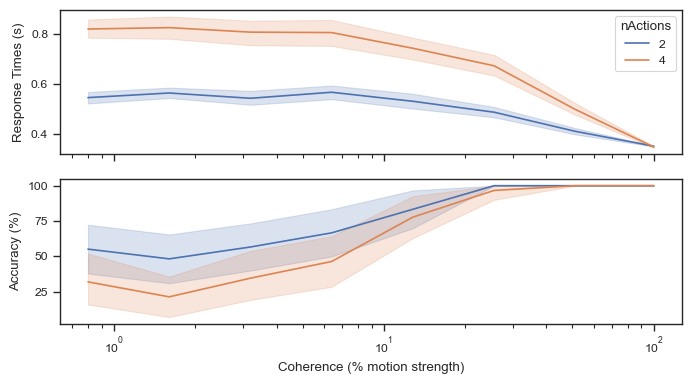

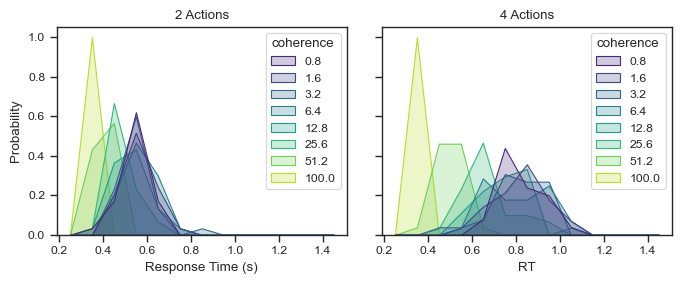

In [19]:
scan_coherence_nActions(load=False, coherences=[0.008, 0.016, 0.032, 0.064, 0.128, 0.256, 0.512, 1.0], threshold=0.25, trials=30)